<div class="title">Aplicaciones de Análisis &ndash; TensorFlow: Práctica</div>
<div class="subtitle">Máster en Big Data y Data Science</div>
<div class="author">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div>

---

<div style="font-size: large; font-weight: bold; margin-left: 2em;">Nombre: Lucian Iacob</div>

**Configuración Inicial**

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

# Enunciado

## Introducción

Se dispone de un conjunto de imágenes etiquetadas como: `cloudy`, `rain`, `shine`, y `sunrise`.

## Objetivo

<div class="qst">

* Crear un modelo con Keras que permita determinar, a partir de una imagen de test, la etiqueta correcta.
    * Se requiere una precisión mínima de entrenamiento del $94\%$. Llegado a este punto se deberá parar el entrenamiento.
    * Dada la complejidad del problema, se deberá:
        * Probar diferentes optimizadores.
        * Probar diferentes tasas de aprendizaje.
        * Variar el número de épocas, el tamaño de los *batchs*, el número de pasos por época...
        * Utilizar diferentes *callbacks* para facilitar la experimentación (por ejemplo, guardando los modelos según se va avanzando).
    * Para cada una de estas comprobaciones, se deberá dar una breve explicación de su funcionamiento y de los resultados obtenidos.

</div>

# Dependencias

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow import keras

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(15, 5))

# Esquema

El *notebook* está organizado mostrando un posible ejemplo de la ruta que se puede seguir para afrontar el problema (aunque no es estrictamente necesario seguir este orden).

Como *baseline* y punto de partida, se realiza la carga de los datos, y se entrena un modelo lineal (perceptrón de clasificación).

## Carga de Datos y Preproceso

* Cargar las imágenes.
* Preprocesar las imágenes.
    * Normalizar la escala.
    * Garantizar que el tamaño sea coherente.
* Generar nuevos ejemplos.
* Ajustar tamaño de *batch*.

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# Parameters.
rescale = 1
image_size = (150, 150)
batch_size = 32

# The image generator can help to preprocess the images.

# In training (and validation), new samples can be generated by modifying this object.
datagen_tr = ImageDataGenerator(
    rescale=1. / 255
)
# In test, new samples should not be added.
datagen_te = ImageDataGenerator(
    rescale=1. / 255
)

# The data is already partitioned by folders, each class is in a different subfolder.
# The following function returns iterators to each dataset.
data_tr = datagen_tr.flow_from_directory(
    "data/train/",
    target_size=image_size,
    batch_size=batch_size,
    seed=123
)
data_va = datagen_tr.flow_from_directory(
    "data/validation/",
    target_size=image_size,
    batch_size=batch_size,
    seed=123
)
data_te = datagen_te.flow_from_directory(
    "data/test/",
    target_size=image_size,
    seed=123
)

Found 900 images belonging to 4 classes.
Found 111 images belonging to 4 classes.
Found 114 images belonging to 4 classes.


* Ejemplo del conjunto de datos.

Batch shape (input):  (32, 150, 150, 3)
Batch shape (target): (32, 4)


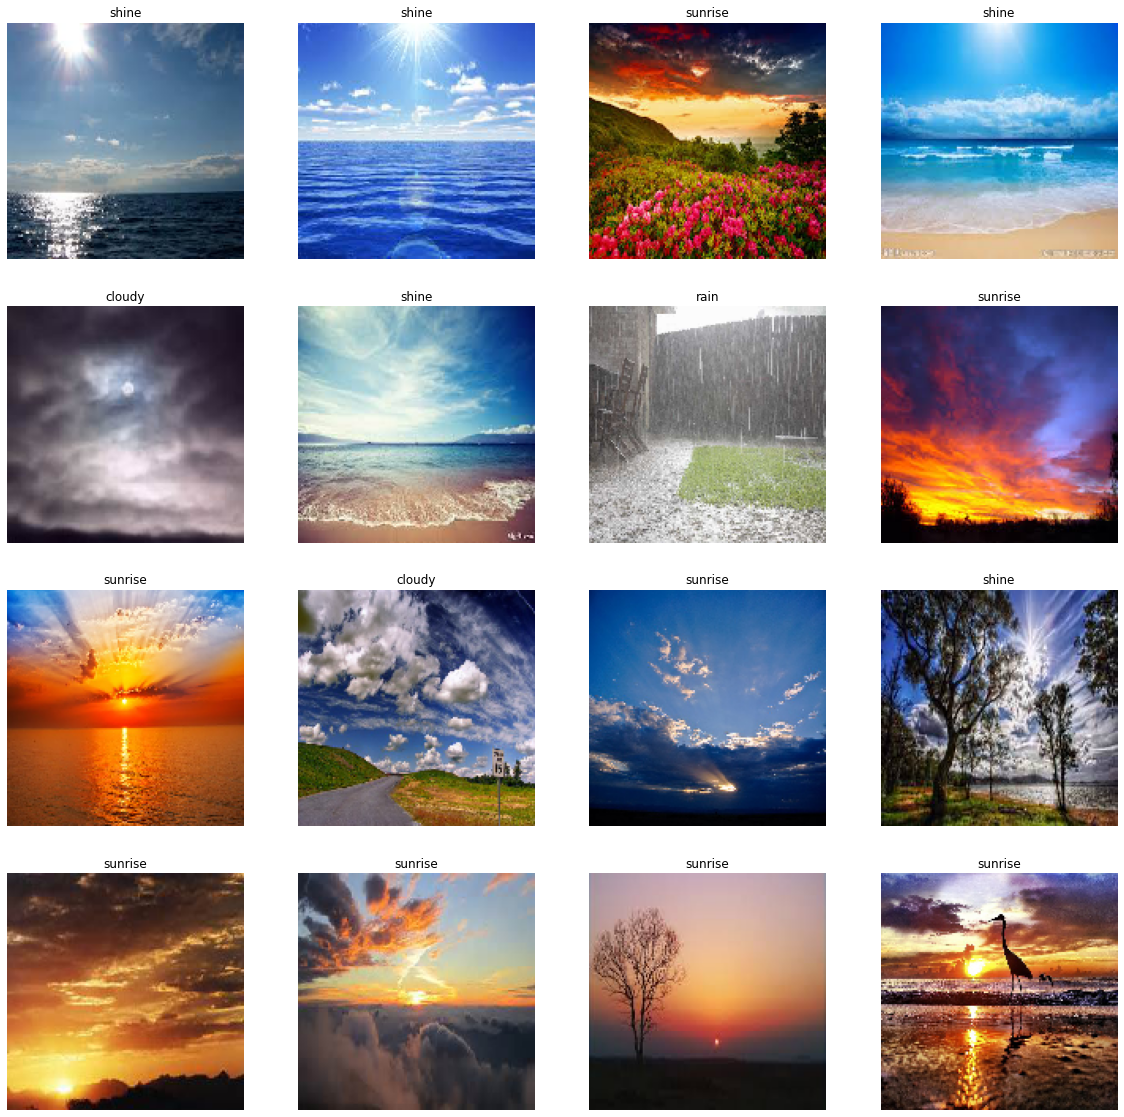

In [4]:
classes = [k for k, v in data_tr.class_indices.items()]

n_rows = 4
n_cols = 4

for batch_x, batch_y in data_tr:
    print("Batch shape (input): ", batch_x.shape)
    print("Batch shape (target):", batch_y.shape)

    plt.figure(figsize=(20, 20))
    for c, x, y in zip(range(len(batch_x)), batch_x, batch_y):
        if c == n_rows * n_cols:
            break

        plt.subplot(n_rows, n_cols, c + 1)
        plt.imshow(x)
        plt.axis("off")
        plt.title(classes[np.where(y)[0][0]])

    plt.show()
    break

## Definición del Modelo

* Ajustar arquitectura.

In [21]:
# A simple perceptron is defined in this case.
model = keras.Sequential(
    [
        keras.layers.Input(shape=(image_size[0], image_size[1], 3)),
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation="softmax")
    ]
)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 67500)             0         
                                                                 
 dense_12 (Dense)            (None, 4)                 270004    
                                                                 
Total params: 270,004
Trainable params: 270,004
Non-trainable params: 0
_________________________________________________________________


## Compilación del Modelo

* Ajustar optimizador.
* Ajustar tasa de aprendizaje.

In [23]:
model.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

## Entrenamiento del Modelo

* Definir *callbacks*.
* Ajustar número de épocas.
* Ajustar el número de pasos por época.

In [24]:
history = model.fit(
    data_tr,
    validation_data=data_va,
    epochs=5,
)

Epoch 1/5
29/29 [==============================] - 5s 157ms/step - loss: 22.2077 - accuracy: 0.4700 - val_loss: 11.9157 - val_accuracy: 0.5045
Epoch 2/5
29/29 [==============================] - 4s 147ms/step - loss: 10.7428 - accuracy: 0.5811 - val_loss: 4.2885 - val_accuracy: 0.7027
Epoch 3/5
29/29 [==============================] - 4s 148ms/step - loss: 11.8246 - accuracy: 0.5911 - val_loss: 3.5427 - val_accuracy: 0.7748
Epoch 4/5
29/29 [==============================] - 4s 154ms/step - loss: 7.8795 - accuracy: 0.6656 - val_loss: 5.5144 - val_accuracy: 0.6577
Epoch 5/5
29/29 [==============================] - 4s 154ms/step - loss: 10.1389 - accuracy: 0.6167 - val_loss: 9.1777 - val_accuracy: 0.6577


## Evaluación del Resultado

* Analizar los errores en entrenamiento y test finales.
* Analizar la evolución de los errores durante el entrenamiento, tanto sobre el conjunto de entrenamiento como sobre el de validación.
* Comprobar el resultado sobre algunas imágenes de forma manual.

In [25]:
[loss, acc] = model.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 54.39%


# Callbacks

Lo primero que realizamos es definir los distintos callbacks que vamos a utilizar para los modelos, definirlos al inicio es conveniente para poder aplicarlos a los distintos modelos.

Primero definimos un callback que pare si no observa mejora en la accuracy de los datos de validación tras 4 iteraciones. Fijarnos en los datos de validación en vez de en los de entrenamiento ayuda a evitar el sobreentrenamiento.

EL siguiente callback lo definimos de acuerdo con los requisitos del enunciado.

In [4]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4)

In [5]:
class MyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if (logs["accuracy"] > 0.94):
            print("Desired accuracy achieved")
            self.model.stop_training = True

my_stopping = MyCallback()

También hay que mencionar que utilizaremos el callback de checkpoint que se quede con el mejor modelo cada vez que lancemos el método fit para evitar quedarnos con algo peor que pueda surgir en épocas posteriores. También porque al reiniciar el kernel nuestro estado puede cambiar y un modelo interesante una vez puede no serlo la siguiente vez que ejecutemos el código.

# Modelo 1

Probamos con una capa densa más en la red, por ir añadiendo complejidad poco a poco, la dotamos de 50 unidades, lo cual nos aumenta el número de parámetros en gran medida (ahora tenemos 20 veces los que teníamos antes). Veamos si añadir una capa así nos produce una mejora sustancial. Aumentamos el número de épocas a 10 para tener un colchón más amplio aprovechando que tenemos un callback que nos parará la ejecución antes en caso de que no haya mejora después de 3 épocas.

Vamos a ir probando con diferentes optimizadores a ver cuál nos resulta mejor:

## Modelo 1 - Adam

In [7]:
checkpoint = keras.callbacks.ModelCheckpoint("model_one_adam", save_best_only=True)

model_one_adam = keras.Sequential(
    [
        keras.layers.Input(shape=(150, 150, 3)),
        keras.layers.Dense(50, activation=tf.nn.relu),
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation="softmax")])

model_one_adam.summary()


model_one_adam.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.Accuracy()],)


history = model_one_adam.fit(
    data_tr,
    validation_data=data_va,
    epochs=10,
    callbacks=[early_stopping, checkpoint, my_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 150, 150, 50)      200       
                                                                 
 flatten_1 (Flatten)         (None, 1125000)           0         
                                                                 
 dense_3 (Dense)             (None, 4)                 4500004   
                                                                 
Total params: 4,500,204
Trainable params: 4,500,204
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
29/29 [==============================] - 10s 335ms/step - loss: 14.8969 - accuracy: 0.3272 - val_loss: 6.7937 - val_accuracy: 0.3919
Epoch 2/10
29/29 [==============================] - 9s 320ms/step - loss: 3.4606 - accuracy: 0.3647 - val_loss: 2.9590 - val_accuracy: 0.3333
Epoch 3/10
29/29 [====

In [8]:
[loss, acc] = model_one_adam.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 28.07%


## Modelo 1 - SGD

Hemos probado con el optimizador Adam recibiendo unos resultados no muy buenos, probemos con el optmizador SGD.

In [9]:
checkpoint = keras.callbacks.ModelCheckpoint("model_one_sgd", save_best_only=True)

model_one_sgd = keras.Sequential(
    [
        keras.layers.Input(shape=(150, 150, 3)),
        keras.layers.Dense(50, activation=tf.nn.relu),
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation="softmax")])

model_one_sgd.summary()


model_one_sgd.compile(
    optimizer=keras.optimizers.SGD(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.Accuracy()],)


history = model_one_sgd.fit(
    data_tr,
    validation_data=data_va,
    epochs=10,
    callbacks=[early_stopping, checkpoint, my_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 150, 150, 50)      200       
                                                                 
 flatten_2 (Flatten)         (None, 1125000)           0         
                                                                 
 dense_5 (Dense)             (None, 4)                 4500004   
                                                                 
Total params: 4,500,204
Trainable params: 4,500,204
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
29/29 [==============================] - 9s 319ms/step - loss: 2.2146 - accuracy: 0.0036 - val_loss: 0.6451 - val_accuracy: 0.0000e+00
Epoch 2/10
29/29 [==============================] - 9s 305ms/step - loss: 0.9140 - accuracy: 5.5556e-04 - val_loss: 1.0186 - val_accuracy: 0.0000e+00
Epoch 3/10
2

In [10]:
[loss, acc] = model_one_sgd.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 3.51%


Los resultados no han sido los mejores. Vamos a probar con el que viene por defecto con el método compile en Keras que es RMSprop.

## Model 1 - RMSprop

In [13]:
checkpoint = keras.callbacks.ModelCheckpoint("model_one_def", save_best_only=True)

model_one_def = keras.Sequential(
    [
        keras.layers.Input(shape=(150, 150, 3)),
        keras.layers.Dense(50, activation=tf.nn.relu),
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation="softmax")])

model_one_def.summary()


model_one_def.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.Accuracy()],)


history = model_one_def.fit(
    data_tr,
    validation_data=data_va,
    epochs=10,
    callbacks=[early_stopping, checkpoint, my_stopping])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 150, 150, 50)      200       
                                                                 
 flatten_4 (Flatten)         (None, 1125000)           0         
                                                                 
 dense_9 (Dense)             (None, 4)                 4500004   
                                                                 
Total params: 4,500,204
Trainable params: 4,500,204
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
29/29 [==============================] - 10s 328ms/step - loss: 39.7120 - accuracy: 0.4458 - val_loss: 22.0992 - val_accuracy: 0.5428
Epoch 2/10
29/29 [==============================] - 9s 322ms/step - loss: 15.1055 - accuracy: 0.4922 - val_loss: 8.0407 - val_accuracy: 0.5676
Epoch 3/10
29/29 [==

In [14]:
[loss, acc] = model_one_def.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 33.99%


Ninguno de los 3 modelos con optimizadores diferentes han producido un resultado mejor que el modelo simple original. Es posible que sea por puro azar y que si lo lanzamos otra vez nos de algo mejor. Pero este primer paso nos vale para sacar en claro que nos quedamos con el optimizador por defecto RMSprop y que necesitamos crear un modelo más concienciudamente, no vale añadir capas porque sí.

# Modelo 2

Tras decidir quedarnos con el optimizador por defecto, vamos a añadir dos características orientadas a evitar el sobreajuste de la red:

* Capa de dropout
* Data augmentation

Estamos ante una cantidad de datos muy pequeña por lo que conviene darle más entradas a nuestra red. También vamos a probar variando el tamaño del batch.

## Modelo original con Data Augmentation y batch_size = 16

In [11]:
rescale = 1
image_size = (150, 150)
batch_size = 16

# Reescribimos toda la celda en vez de cambiar el batch_size por tener todo junto a cada vez que lo lancemos

datagen_tr = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# In test, new samples should not be added.
datagen_te = ImageDataGenerator(
    rescale=1. / 255
)

data_tr = datagen_tr.flow_from_directory(
    "data/train/",
    target_size=image_size,
    batch_size=batch_size,
    seed=123
)
data_va = datagen_tr.flow_from_directory(
    "data/validation/",
    target_size=image_size,
    batch_size=batch_size,
    seed=123
)
data_te = datagen_te.flow_from_directory(
    "data/test/",
    target_size=image_size,
    seed=123
)

Found 900 images belonging to 4 classes.
Found 111 images belonging to 4 classes.
Found 114 images belonging to 4 classes.


Para comprobar la efectividad de este método de data agumentation, vamos a crear un modelo igual al original para ver cuánto mejora la predicción.

In [16]:
checkpoint = keras.callbacks.ModelCheckpoint("model_two_16", save_best_only=True)

model_two_16 = keras.Sequential(
    [
        keras.layers.Input(shape=(image_size[0], image_size[1], 3)),
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation="softmax")])


model_two_16.summary()


model_two_16.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy"],)


history = model_two_16.fit(
    data_tr,
    validation_data=data_va,
    epochs=10,
    callbacks=[early_stopping, checkpoint, my_stopping])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 67500)             0         
                                                                 
 dense_10 (Dense)            (None, 4)                 270004    
                                                                 
Total params: 270,004
Trainable params: 270,004
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
57/57 [==============================] - 8s 144ms/step - loss: 20.0009 - accuracy: 0.4667 - val_loss: 8.0661 - val_accuracy: 0.6667
Epoch 2/10
57/57 [==============================] - 8s 145ms/step - loss: 13.3516 - accuracy: 0.5589 - val_loss: 11.9908 - val_accuracy: 0.5766
Epoch 3/10
57/57 [==============================] - 8s 142ms/step - loss: 11.7352 - accuracy: 0.5833 - val_loss: 19.0620 - val_accuracy: 0.5135
Epoch 4/10
57

In [17]:
[loss, acc] = model_two_16.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 67.54%


Vemos cómo ha mejorado significativamente nuestra precisión solo como el data augmentation, nos quedamos con esta metodología. Ahora vayamos a probar con tamaño de batch de 32.

## Modelo original con Data Augmentation y batch_size = 32

In [6]:
rescale = 1
image_size = (150, 150)
batch_size = 32

datagen_tr = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# In test, new samples should not be added.
datagen_te = ImageDataGenerator(
    rescale=1. / 255
)

data_tr = datagen_tr.flow_from_directory(
    "data/train/",
    target_size=image_size,
    batch_size=batch_size,
    seed=123
)
data_va = datagen_tr.flow_from_directory(
    "data/validation/",
    target_size=image_size,
    batch_size=batch_size,
    seed=123
)
data_te = datagen_te.flow_from_directory(
    "data/test/",
    target_size=image_size,
    seed=123
)

Found 900 images belonging to 4 classes.
Found 111 images belonging to 4 classes.
Found 114 images belonging to 4 classes.


In [19]:
checkpoint = keras.callbacks.ModelCheckpoint("model_two_32", save_best_only=True)

model_two_32 = keras.Sequential(
    [
        keras.layers.Input(shape=(image_size[0], image_size[1], 3)),
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation="softmax")])


model_two_32.summary()


model_two_32.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],)


history = model_two_32.fit(
    data_tr,
    validation_data=data_va,
    epochs=10,
    callbacks=[early_stopping, checkpoint, my_stopping])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 67500)             0         
                                                                 
 dense_11 (Dense)            (None, 4)                 270004    
                                                                 
Total params: 270,004
Trainable params: 270,004
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
29/29 [==============================] - 8s 272ms/step - loss: 23.4187 - accuracy: 0.3978 - val_loss: 7.8296 - val_accuracy: 0.5856
Epoch 2/10
29/29 [==============================] - 7s 257ms/step - loss: 12.4110 - accuracy: 0.5256 - val_loss: 23.1654 - val_accuracy: 0.4775
Epoch 3/10
29/29 [==============================] - 8s 263ms/step - loss: 14.0782 - accuracy: 0.5278 - val_loss: 9.3133 - val_accuracy: 0.7027
Epoch 4/10
29/

In [20]:
[loss, acc] = model_two_32.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 81.58%


Con un modelo tan sencillo como el original y data augmentation hemos llegado a un 81.2% de precisión, realmente sorprendente.

Hagamos un último intento con batch size tamaño 8.

## Modelo original con Data Augmentation y batch_size = 8

In [51]:
rescale = 1
image_size = (150, 150)
batch_size = 8

datagen_tr = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# In test, new samples should not be added.
datagen_te = ImageDataGenerator(
    rescale=1. / 255
)

data_tr = datagen_tr.flow_from_directory(
    "data/train/",
    target_size=image_size,
    batch_size=batch_size,
    seed=123
)
data_va = datagen_tr.flow_from_directory(
    "data/validation/",
    target_size=image_size,
    batch_size=batch_size,
    seed=123
)
data_te = datagen_te.flow_from_directory(
    "data/test/",
    target_size=image_size,
    seed=123
)

Found 900 images belonging to 4 classes.
Found 111 images belonging to 4 classes.
Found 114 images belonging to 4 classes.


In [28]:
checkpoint = keras.callbacks.ModelCheckpoint("model_two_8", save_best_only=True)

model_two_8 = keras.Sequential(
    [
        keras.layers.Input(shape=(image_size[0], image_size[1], 3)),
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation="softmax")])


model_two_8.summary()


model_two_8.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],)


history = model_two_8.fit(
    data_tr,
    validation_data=data_va,
    epochs=10,
    callbacks=[early_stopping, checkpoint, my_stopping])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 67500)             0         
                                                                 
 dense_13 (Dense)            (None, 4)                 270004    
                                                                 
Total params: 270,004
Trainable params: 270,004
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
113/113 [==============================] - 9s 73ms/step - loss: 16.3703 - accuracy: 0.4967 - val_loss: 8.3469 - val_accuracy: 0.5405
Epoch 2/10
113/113 [==============================] - 9s 78ms/step - loss: 13.2854 - accuracy: 0.5778 - val_loss: 5.2943 - val_accuracy: 0.6757
Epoch 3/10
113/113 [==============================] - 9s 77ms/step - loss: 12.6768 - accuracy: 0.6078 - val_loss: 5.3990 - val_accuracy: 0.7027
Epoch 4/10
1

In [29]:
[loss, acc] = model_two_8.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 78.95%


Se ha obtenido un valor también elevado para batch size 8. 

Otros valores más pequeños no deberían suponer mucha diferencia y valores superiores a 32, teniendo en cuenta el tamaño de nuestro dataset, quizás sean demasiado. 

Tras ver que realmente influye esto, en los modelos posteriores, se probará con estos 3 valores pero solo se mostrará el mejor resultado dejando indicado cuál se ha usado para evitar repeticiones y poder ir probando con otros parámetros.

# Modelo 3

Añadimos una capa densa, un dropout que evite sobreentrenamiento y nos basamos en data augmentation. 

Al utilizar dropout, conviene aumentar el tamaño de la red (unidades) y la tasa de aprendizaje, probemos con distintos valores, aunque primero mostraremos los resultados con los valores por defecto del optimizador por ver de dónde partimos.

Nos han dado los mejores (e iguales) resultados los tamaños 8 y 16 de batch en este caso.

## Modelo 3 por defecto

In [130]:
checkpoint = keras.callbacks.ModelCheckpoint("model_three_default", save_best_only=True)

model_three_default = keras.Sequential(
    [
        keras.layers.Input(shape=(image_size[0], image_size[1], 3)),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation="softmax")])


model_three_default.summary()


model_three_default.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],)


history = model_three_default.fit(
    data_tr,
    validation_data=data_va,
    epochs=15,
    callbacks=[early_stopping, checkpoint, my_stopping])

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_106 (Dense)           (None, 150, 150, 64)      256       
                                                                 
 dropout_77 (Dropout)        (None, 150, 150, 64)      0         
                                                                 
 flatten_53 (Flatten)        (None, 1440000)           0         
                                                                 
 dense_107 (Dense)           (None, 4)                 5760004   
                                                                 
Total params: 5,760,260
Trainable params: 5,760,260
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
113/113 [==============================] - 27s 235ms/step - loss: 20.1344 - accuracy: 0.6267 - val_loss: 5.8231 - val_accuracy: 0.6847
Epoch 2/15
113/113 [=========

In [131]:
[loss, acc] = model_three_default.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 85.96%


##  Modelo 3 modificado

Nuestra base es un 86% en este tercer modelo algo más complejo. A continuación mostramos los mejores resultados obtenidos tras probar con un grid de:

learn_rate = 0.001 | 0.01 | 0.1 | 0.2 | 0.3 

momentum = 0.0 | 0.2 | 0.4 | 0.6 | 0.8 | 0.9

In [34]:
checkpoint = keras.callbacks.ModelCheckpoint("model_three_00102", save_best_only=True)

model_three_00102 = keras.Sequential(
    [
        keras.layers.Input(shape=(image_size[0], image_size[1], 3)),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation="softmax")])


model_three_00102.summary()


model_three_00102.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.2),
    loss="categorical_crossentropy",
    metrics=["accuracy"],)


history = model_three_00102.fit(
    data_tr,
    validation_data=data_va,
    epochs=20,
    callbacks=[early_stopping, checkpoint, my_stopping])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 150, 150, 128)     512       
                                                                 
 dropout_23 (Dropout)        (None, 150, 150, 128)     0         
                                                                 
 flatten_23 (Flatten)        (None, 2880000)           0         
                                                                 
 dense_47 (Dense)            (None, 4)                 11520004  
                                                                 
Total params: 11,520,516
Trainable params: 11,520,516
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
57/57 [==============================] - 32s 549ms/step - loss: 35.7380 - accuracy: 0.5933 - val_loss: 3.7887 - val_accuracy: 0.8559
Epoch 2/20
57/57 [===========

In [45]:
[loss, acc] = model_three_00102.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 91.23%


Tras la ejecución de ese grid, el mejor resultado vino dado por lr=00.1 (por defecto) y momentum (0.2) con batch_size=16. Hemos llegado a un 91.23 de acierto con el dataset de test, luego ya tenemos unos valores aceptables. Problemos a complicar un poco más el modelo.

# Modelo 4

Ahora añadimos una capa convolucional que tan bien suelen ir para identificar formas en las imágenes junto una de max pooling para reducir variables además de las capas anteriores para ver si mejoramos el modelo anterior.

## Modelo 4 inicial

In [16]:
checkpoint = keras.callbacks.ModelCheckpoint("model_four", save_best_only=True)

model_four = keras.Sequential(
    [   keras.layers.Conv2D(32, kernel_size=(3,3),  activation="relu", input_shape=(image_size[0], image_size[1], 3)),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation="softmax")])


model_four.summary()

model_four.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)



history = model_four.fit(
    data_tr,
    validation_data=data_va,
    epochs=20,
    callbacks=[early_stopping, checkpoint, my_stopping])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dense_6 (Dense)             (None, 74, 74, 128)       4224      
                                                                 
 dropout_3 (Dropout)         (None, 74, 74, 128)       0         
                                                                 
 flatten_3 (Flatten)         (None, 700928)            0         
                                                                 
 dense_7 (Dense)             (None, 4)                 2803716   
                                                      

In [17]:
[loss, acc] = model_four.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 76.32%


Si nos fijamos en la historia de entrenamiento, vemos que la última época es bastante peor que la que se ha guardado con los datos de validación. Por ello, calculemos la preción con ambas posibilidades para comprobarlo:

In [18]:
model_four_imported = keras.models.load_model('model_four')

[loss, acc] = model_four_imported.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 92.98%


Vemos que el modelo guardado en mucho mejor que el de la última época. Es de hecho nuestro mejor modelo hasta el momento, alcanzando una precisión del 93%.

Lo mejor de este modelo frente al modelo 3 es que hemos reducido los parámetros de 11 millones a 2.8 por lo que el coste computacional es menor.

Cabe destacar que estos resultados se han alcanzado con un batch_size=8. Veamos si cambiando un poco los hiperparámetros conseguimos algo mejor.

## Modelo 4 mejorado

Nuestras imágenes tienen un tamaño considerable, por eso supuestamente conviene aumentar el tamaño del kernel de la capa convolucional para que capture formas más grandes. Se ha probado con los valores (5,5) y (7,7) además de variar el número de filtros. No obstante, los mejores resultados tras muchas pruebas variando número de filtros, tamaño de kernel, probabilidad de dropout, learning rate y momento es este modelo bastante más sencillo en cuanto a parámetros.

In [13]:
checkpoint = keras.callbacks.ModelCheckpoint("model_four_mod_2", save_best_only=True)

model_four_mod_2 = keras.Sequential(
    [   keras.layers.Conv2D(20, kernel_size=(3,3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dense(15, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation="softmax")])

model_four_mod_2.summary()

model_four_mod_2.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model_four_mod_2.fit(
    data_tr,
    validation_data=data_va,
    epochs=20,
    callbacks=[early_stopping, checkpoint, my_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 20)      560       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 20)       0         
 2D)                                                             
                                                                 
 dense_4 (Dense)             (None, 74, 74, 15)        315       
                                                                 
 dropout_2 (Dropout)         (None, 74, 74, 15)        0         
                                                                 
 flatten_2 (Flatten)         (None, 82140)             0         
                                                                 
 dense_5 (Dense)             (None, 4)                 328564    
                                                      

In [14]:
[loss, acc] = model_four_mod_2.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 92.98%


Probamos con el modelo guardado en el checkpoint a ver si funciona mejor.

In [15]:
model_four_mod_2_imported = keras.models.load_model('model_four_mod_2')

[loss, acc] = model_four_mod_2_imported.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 93.86%


Con este modelo con 330 mil parámetros hemos conseguido un 94% de precisión en el test. Solo una mejora del 2% respecto al modelo 3 pero con 10 veces menos parámetros por lo que se puede considerar un éxito.

Después de esto se probaron modelos con más capas convolucionales en los que aumentaban los filtros a cada capa y sucesiones de capas densas con dropouts similares a lo visto en clase, pero no se consiguieron resultados mejores así que he visto conveniente dejarlo en este modelo que ya alcanza unos porcentajes muy elevados de acierto.

Cabe destacar que ente caso menos es más. Con esta red tan sencilla, con pocas unidades, hemos llegado a casi un 94% de acierto, sin tener que hacer un fine tuning excesivo para ello.